**Importation des packages**

In [89]:
import sys

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# la ligne ici est ajouté principalement pour SVC dont des mises à jour
# sont annoncées mais jamais mise à jour :)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf

#inflect est une librairie qui permet de convertir les nombres en mots
import inflect

import pickle
import contractions
import unicodedata
from collections import Counter
import math
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import uniform
import re
import json
import numpy
from time import time
import pandas as pd
import numpy as np 
import sklearn
from sklearn.utils import resample
from sklearn_pandas import DataFrameMapper
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package punkt to /home/anas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<h1> Etude Préliminaire</h1>

Lecture du CSV issue de ClaimsKG

In [2]:
df=pd.read_csv('claim.csv', sep=',')



In [ ]:
shapeDF = df.shape
nbLignes, nbColonnes = shapeDF
print("On a", nbLignes, "lignes et", nbColonnes,"colonnes")

print("Cinq premières lignes du dataframe :")
display(df[:5])
# ou :
#display(df.head(5))

print("Information sur le dataframe : ")

print (df.info())

On peut déjà retirer la colonne Unnamed qui ne nous sera pas utile par la suite, elle indexe juste les claims par rapport à la source

In [4]:
df=df.drop("Unnamed: 0", 1)

On cherche Maintenant a savoir comment est formé notre DataFrame avec les données disponibles

Nombre de colonne où il y a au moins une valeur nulle : 15



['claimReview_author',
 'claimReview_author_url',
 'claimReview_claimReviewed',
 'claimReview_datePublished',
 'creativeWork_author_name',
 'creativeWork_author_sameAs',
 'creativeWork_datePublished',
 'extra_body',
 'extra_refered_links',
 'extra_tags',
 'extra_title',
 'rating_alternateName',
 'rating_bestRating',
 'rating_ratingValue',
 'rating_worstRating']

Heatmap des valeurs manquantes :


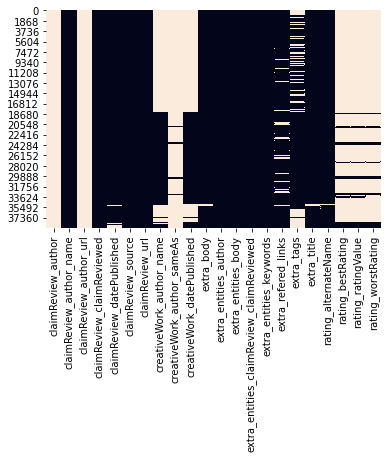

In [5]:
sns.heatmap(df.isnull(), cbar=False)

colonnesNonCompletes = []

for colonne in df.columns.values:
        if(df[colonne].isnull().any()):
            colonnesNonCompletes.append(colonne)

print( "Nombre de colonne où il y a au moins une valeur nulle :", len(colonnesNonCompletes))
print( "")
display(colonnesNonCompletes)

print( "Heatmap des valeurs manquantes :")

<H1> Pré-traitement </H1>

La première phase du projet consiste à faire du feature engineering. C'est à dire qu'il faudra utiliser des méthodes de traitement de données afin de préparer notre dataset à la phase de classification.

**Attribution des valeurs de classe**

On choisit dans un premier temps d'utiliser la méthode de classification suivante : 
{VRAI} vs. {FAUX}

On va alors parcourir la colonne 'rating_alternateName' puis attribuer la valeur '1' pour toutes les assertions 'True' et 0 pour tout le reste. On admet que si ce n'est pas entièrement true, c'est false.

In [6]:
df2 = df.copy()
print(nbLignes)
indexAlternateName = 0
while indexAlternateName < nbLignes:
    phrase = df['rating_alternateName'][indexAlternateName]
    
    #key = df['extra_entities_keywords'][indexAlternateName]
    if  isinstance(phrase, str):
        #tokenization de la phrase
        tokens = word_tokenize(phrase)

        #mise en minuscules 
        tokens = [w.lower() for w in tokens]
        
        if tokens[0] == "true":
            #print("True")
            df2['rating_alternateName'][indexAlternateName] = 1
            
        else:
            df2['rating_alternateName'][indexAlternateName] = 0
            #print(indexAlternateName, " : ", tokens)
    #else:
        #print(indexAlternateName, " : entrée vide")
    #if  isinstance(key, str): #recuperer le sujet de la phrase
        #print(key)
    indexAlternateName+=1
    
indexAlternateName2 = 0
while indexAlternateName2 < nbLignes:
    sujet = df['extra_tags'][indexAlternateName2]
    
    if  isinstance(sujet, str): #recuperer le sujet de la phrase
        x = sujet.split(",")
        #print(indexAlternateName, " : ", x[0])
        df2['extra_tags'][indexAlternateName2] = x[0]
        #print(df2['extra_tags'][indexAlternateName2])
    else : 
        df2 = df2.drop([indexAlternateName2], axis = 0)
    indexAlternateName2+=1
df2.reset_index(drop=True, inplace=True)
    

39218


/home/anas/Bureau/m1-aigle-s2/HMIN232M-DataScienceMethods/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/anas/Bureau/m1-aigle-s2/HMIN232M-DataScienceMethods/env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/anas/Bureau/m1-aigle-s2/HMIN232M-DataScienceMethods/env/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

**Affichage des résultats**

On affiche le nombre d'assertions true/false (attribut rating_alternateName) avec countplot.

Pour nous :
- Une assertion vraie est attribuée à la valeur 1
- Une assertion non vraie est attribuée à la valeur 0

In [7]:
df2.rating_alternateName.sample(5)

15806    0
18502    0
16906    0
14763    1
17087    0
Name: rating_alternateName, dtype: object

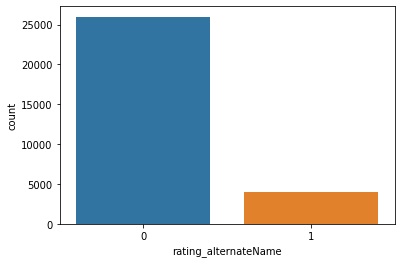

In [8]:
sns.countplot(x='rating_alternateName', data=df2)

**Transformation des phrases d'assertions**



On commence par lancer un processus de transformation sur la colonne 'claimReview_claimReviewed' :

In [9]:
shapeDF = df2.shape
nbLignes, nbColonnes = shapeDF

def replace_contractions(text):
    return contractions.fix(text)

def remove_non_ascii(text):
    new_words = []
    for word in text:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return text

def replace_digits(text):
    p = inflect.engine()
    indiceWord = 0
    tokens2 = ""
    for word in text:
        if word.isdigit():
            text[indiceWord] = p.number_to_words(word)
            phrase2 = sent_tokenize(text[indiceWord])
            tokens2 = word_tokenize(phrase2[0]) #tokenisation de la conversion du digit
            text = text[:indiceWord] + tokens2 + text[indiceWord+1:]
        indiceWord+=1
    return text

def lemmatisation_text(text):
    #Lemmatisation
    wordnet_lemmatizer = WordNetLemmatizer()
    text = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in text]
    return text

def stemmatisation_text(text):
    #Stemmatisation
    porter = PorterStemmer()
    text = [porter.stem(word) for word in text]
    return text

def pos_tag_text(text):
    text = nltk.pos_tag(text)
    return text

def clean_text(text):
    #on supprime les contractions
    text = replace_contractions(text)
    #on tokenize la phrase
    text = word_tokenize(text)
    #on remplace les chiffres par leur équivalent écrit en lettres
    text = replace_digits(text) 
    #mise en minuscules 
    text = [w.lower() for w in text]
    #suppression des ponctuations
    text = [word for word in text if word.isalpha()] 
     #suppression des stop words
    stop_words = set(stopwords.words('english'))
    text = [w for w in text if not w in stop_words] 
    #Stemmatisation
    text = stemmatisation_text(text)
    #On remet le texte sous forme d'une phrase
    text="".join([" "+i for i in text]).strip()
    return text

#on traite chaque ligne de la colonne 'claimReview_claimReviewed'

cleanClaimsLms = []

print("Pré-traitement en cours...")
t0 = time()
indexClaimReviewed=0
while indexClaimReviewed < nbLignes:
    ligne = df['claimReview_claimReviewed'][indexClaimReviewed]
    #print("Progression : ",indexClaimReviewed,"/",nbLignes, end="\r")
    #On vérifie si la ligne est bien une chaîne de caractères 'str' non vide, autrement on la supprime du dataset
    if isinstance(ligne, str) and ligne:
        #On découpe en phrase pour prendre la première, qui correspond à l'assertion
        phrase = sent_tokenize(ligne)[0]
        
        phrase = clean_text(phrase)
        
        cleanClaimsLms.append(phrase)     
           
    #Dans le cas d'une claim vide, on enlève toute la ligne comme elle ne pourra pas nous être utile
    else:       
        #On supprime toute l'entrée
        df2 = df2.drop(df2.index[indexClaimReviewed])
        
    indexClaimReviewed+=1
    
print("Pré-traitement terminée en %0.3fs" % (time() - t0))
#On ré-assigne les index pour re-synchroniser les entrées supprimées   
df2.reset_index(drop=True, inplace=True)


Pré-traitement en cours...
Pré-traitement terminée en 15.672s


In [10]:
#On crée une nouvelle colonne avec les claims nettoyées
df2['claimReview_Cleaned'] = cleanClaimsLms   


In [11]:
display(df2['claimReview_Cleaned'].sample(5))

21818    never direct suprem court case peopl illeg whe...
26767    medicar good better keep peopl healthi medicar...
12661                     credit card charg laundri servic
23239    say texa board nurs backlog complaint nurs man...
18449    monica lewinski offer take one team perform or...
Name: claimReview_Cleaned, dtype: object

On stocke le résultat de la transformation dans une nouvelle colonne du dataframe 'df2' qui va nous servir plus tard pour la classification. (On garde les données originales dans 'df')

**Extractions des URLs :** 
Nous obtenons les URLs grâce a un pattern qui correspond a la valeur entre http et le premier "/"

In [12]:
def get_urls_from_text(text):
    domain2=re.findall('https?:\/\/(?:www\.)?([^\/]+)', text)
    #print("Url : " + url)
    urls = []
    #suppression des doublons
    for j in domain2:
        if j not in urls:
            urls.append(j)
    #url ="".join([" "+i for i in urls]).strip()
    #return url
    if(len(urls) > 1):
        return urls[0]
    else:
        return "NaN"
    

minimized_urls = []
idx = 0
t0 = time()
nbLignes, nbColonnes = df2.shape

print("Traitement des urls en cours...")

while idx < nbLignes:
    #print("Ligne ",idx)
    url = df2['extra_refered_links'][idx]
    if isinstance(url, str) and url:
        url = sent_tokenize(url)[0]
        url = get_urls_from_text(url)
        minimized_urls.append(url)
    else:
        minimized_urls.append("")
        
    idx+=1
print("Traitement des urls terminé en %0.3fs" % (time() - t0))

Traitement des urls en cours...
Traitement des urls terminé en 202.872s


In [13]:
#On crée une nouvelle colonne avec les urls nettoyées
df2['minimized_urls'] = minimized_urls   
display(df2['minimized_urls'].sample(5))

21632                     
4907     stemcells.nih.gov
19286          nces.ed.gov
6392       nydailynews.com
9648                   NaN
Name: minimized_urls, dtype: object

**Extraction des entités**

Après avoir observé quelques lignes de la colonne 'extra_entities_claimReview_claimReviewed', on a constaté que certaines entrées JSON étaient mal formées. Cette fonction permet de les corriger dans la plupart des cas :

In [14]:
#Traitement JSON colone extra_entities_claimReview_claimReviewed 
def fix_json_string(line_string):
    result = line_string.replace('",""begin"', ',"begin"')
    return result

df2['fixed_extra_claimReviewed'] = df['extra_entities_claimReview_claimReviewed'].apply(lambda x: fix_json_string(x))

On peut maintenant récupérer les entités en parsant les JSON qu'on vient de réparer :

In [15]:
#Récupération entity
def get_entity(fixed_line):
    try : 
        meta_data = json.loads(fixed_line)
        result = [item['entity'] for item in meta_data]
        return result
    except ValueError:  
        return 'NaN'
    
#Récupération category
def get_category(fixed_line):
    meta_data = json.loads(fixed_line)
    result = [item['categories'] for item in meta_data]
    return result

#Récupération score
def get_score(fixed_line):
    try:
        meta_data = json.loads(fixed_line)
        result = [item['score'] for item in meta_data]
        if(len(result) > 1):
            return result[0]
        else:
            return float('NaN')
    except ValueError:
        return float('NaN')

def stringify(liste):
    if liste == "NaN" or not liste:
        return "NaN"
    else:
        #text="".join([""+i for i in liste]).strip()
        #return text
        return liste[0]


#Création colonne des entités dans notre dataframe
df2['fixed_entities'] = df2['fixed_extra_claimReviewed'].apply(lambda x: get_entity(x))
df2['fixed_score_entities'] = df2['fixed_extra_claimReviewed'].apply(lambda x: get_score(x))
df2['fixed_entities'] = df2['fixed_entities'].apply(lambda x: stringify(x))


Affichage des entités :

In [16]:
df2.iloc[0:50]

,claimReview_author,claimReview_author_name,claimReview_author_url,claimReview_claimReviewed,claimReview_datePublished,claimReview_source,claimReview_url,creativeWork_author_name,creativeWork_author_sameAs,creativeWork_datePublished,...,extra_title,rating_alternateName,rating_bestRating,rating_ratingValue,rating_worstRating,claimReview_Cleaned,minimized_urls,fixed_extra_claimReviewed,fixed_entities,fixed_score_entities
0,NaN,snopes,NaN,"U.S. Rep. Adam Schiff is """"linked"""" to a Ukrai...",2019-10-03,snopes,https://www.snopes.com/fact-check/adam-schiff-...,NaN,NaN,NaN,...,Is Adam Schiff ‘Linked’ to a ‘Prominent Ukrain...,0,NaN,NaN,NaN,finnish presid sauli niinistö post video white...,mediabiasfactcheck.com,"[{""id"" : 1042690,""begin"": 18,""end"": 32,""entity...",Sauli Niinistö,0.64
1,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,support alexandria suggest eat babi combat cli...,latinospost.com,"[{""id"" : 54885332,""begin"": 22,""end"": 45,""entit...",Alexandria Ocasio-Cortez,0.56
2,NaN,snopes,NaN,"The intelligence community """"secretly eliminat...",2019-10-01,snopes,https://www.snopes.com/fact-check/whistleblowe...,NaN,NaN,NaN,...,Did US Intelligence Eliminate a Requirement Th...,0,NaN,NaN,NaN,photograph show bride groom handmaid tale wed,npr.org,"[{""id"" : 50430110,""begin"": 46,""end"": 61,""entit...",The Handmaid's Tale (TV series),NaN
3,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,canada legal medicin use cocain,latinospost.com,"[{""id"" : 7701,""begin"": 38,""end"": 45,""entity"": ...",Cocaine,NaN
4,NaN,snopes,NaN,Betsy Ross made the first American flag (or on...,2019-09-27,snopes,https://www.snopes.com/fact-check/betsy-ross-q...,NaN,NaN,NaN,...,Was Betsy Ross a Quaker Who Was Opposed to Sla...,0,NaN,NaN,NaN,septemb two thousand nineteen presid donald tr...,snopes.com,"[{""id"" : 4848272,""begin"": 31,""end"": 43,""entity...",Donald Trump,0.64
5,NaN,snopes,NaN,A Fox News guest disparaged teenage climate ac...,2019-09-25,snopes,https://www.snopes.com/fact-check/fox-news-gue...,NaN,NaN,NaN,...,Did a Fox News Guest Disparage Teen Climate Ac...,1,NaN,NaN,NaN,monica lewinski offer take one team perform or...,mediabiasfactcheck.com,"[{""id"" : 19948,""begin"": 0,""end"": 15,""entity"": ...",Monica Lewinsky,0.63
6,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,nasa noaa fake climat data gistemp global temp...,latinospost.com,"[{""id"" : 18426568,""begin"": 0,""end"": 4,""entity""...",NASA,0.61
7,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,septemb two thousand nineteen hous democrat vo...,latinospost.com,"[{""id"" : 1129641,""begin"": 75,""end"": 99,""entity...",Electronic health record,NaN
8,NaN,snopes,NaN,A leprosy outbreak was looming in Los Angeles ...,2019-09-19,snopes,https://www.snopes.com/fact-check/leprosy/,NaN,NaN,NaN,...,Is a Leprosy Outbreak Looming in Los Angeles?,0,NaN,NaN,NaN,adam schiff link ukrainian arm dealer,nbcnews.com,"[{""id"" : 408932,""begin"": 7,""end"": 18,""entity"":...",Adam Schiff,NaN
9,NaN,snopes,NaN,An image shows a village of shacks in Los Ange...,2019-09-18,snopes,https://www.snopes.com/fact-check/conditions-i...,NaN,NaN,NaN,...,Does a Picture Show a Shanty Town in Los Angeles?,0,NaN,NaN,NaN,abc cb nbc msnbc npr pb refus cover abortionis...,facebook.com,"[{""id"" : 62027,""begin"": 0,""end"": 3,""entity"": ""...",American Broadcasting Company,0.44


Affichage de l'histogramme des valeurs des scores

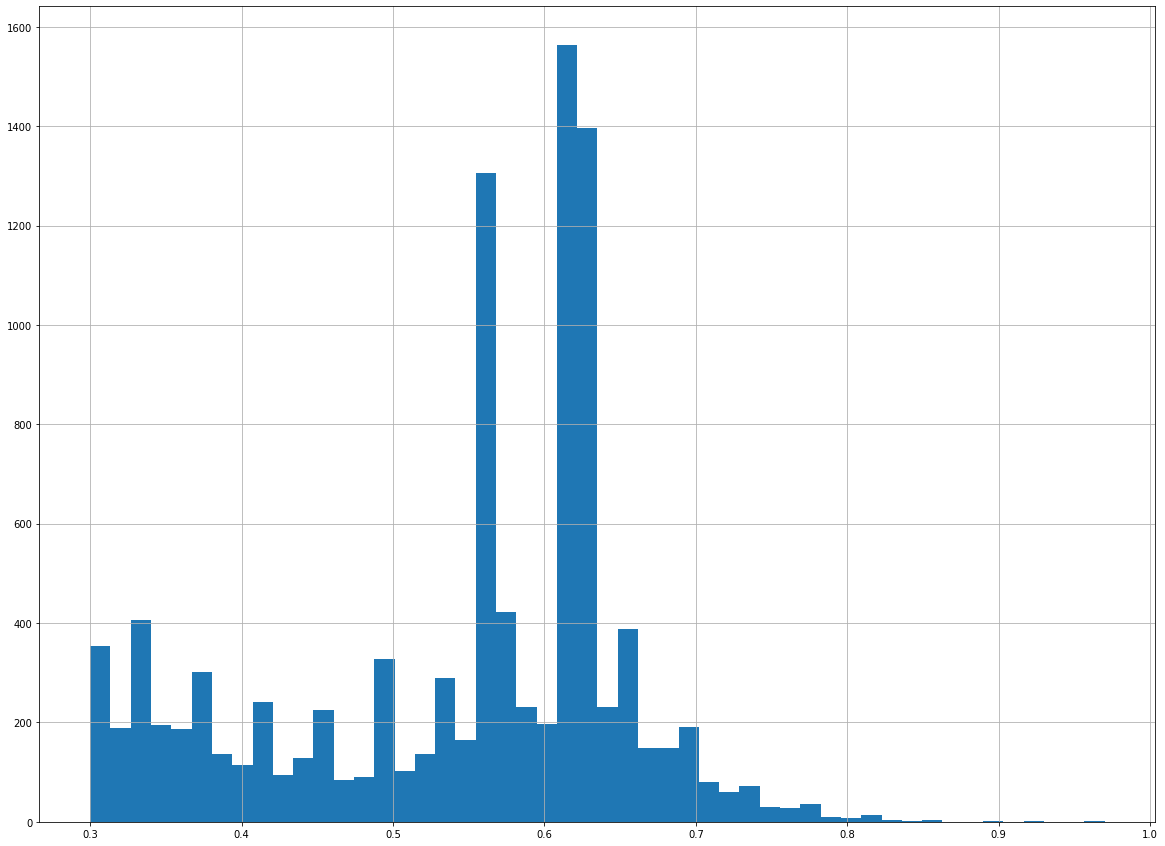

In [17]:
df2['fixed_score_entities'].hist(bins=50, figsize=(20, 15))
plt.show()

In [18]:
#on applique la valeur moyenne aux entrées nulles
mean_score = df2['fixed_score_entities'].mean()
df2['fixed_score_entities'] = df2['fixed_score_entities'].fillna(mean_score)

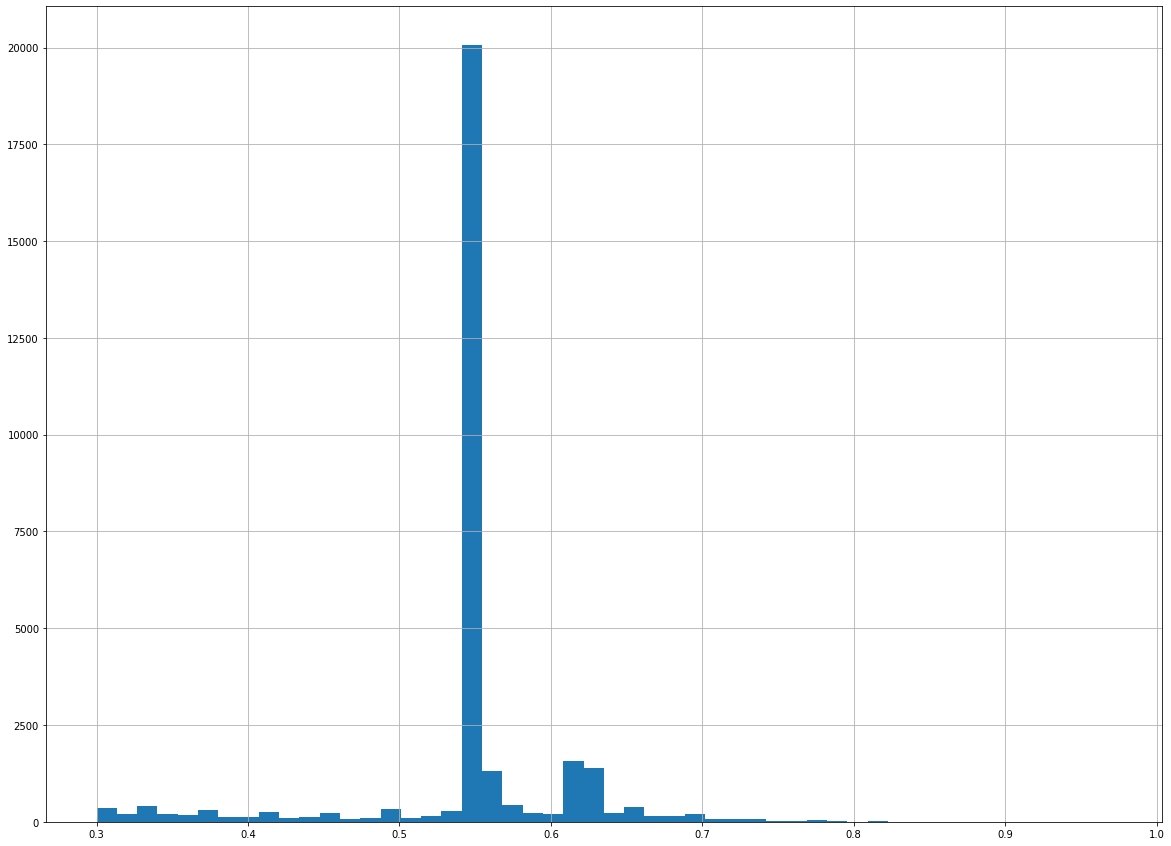

In [19]:
df2['fixed_score_entities'].hist(bins=50, figsize=(20, 15))
plt.show()

In [20]:
df2['claimReview_datePublished'] = df2['claimReview_datePublished'].fillna('NaN')

In [21]:
df2.iloc[0:50]

,claimReview_author,claimReview_author_name,claimReview_author_url,claimReview_claimReviewed,claimReview_datePublished,claimReview_source,claimReview_url,creativeWork_author_name,creativeWork_author_sameAs,creativeWork_datePublished,...,extra_title,rating_alternateName,rating_bestRating,rating_ratingValue,rating_worstRating,claimReview_Cleaned,minimized_urls,fixed_extra_claimReviewed,fixed_entities,fixed_score_entities
0,NaN,snopes,NaN,"U.S. Rep. Adam Schiff is """"linked"""" to a Ukrai...",2019-10-03,snopes,https://www.snopes.com/fact-check/adam-schiff-...,NaN,NaN,NaN,...,Is Adam Schiff ‘Linked’ to a ‘Prominent Ukrain...,0,NaN,NaN,NaN,finnish presid sauli niinistö post video white...,mediabiasfactcheck.com,"[{""id"" : 1042690,""begin"": 18,""end"": 32,""entity...",Sauli Niinistö,0.640000
1,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,support alexandria suggest eat babi combat cli...,latinospost.com,"[{""id"" : 54885332,""begin"": 22,""end"": 45,""entit...",Alexandria Ocasio-Cortez,0.560000
2,NaN,snopes,NaN,"The intelligence community """"secretly eliminat...",2019-10-01,snopes,https://www.snopes.com/fact-check/whistleblowe...,NaN,NaN,NaN,...,Did US Intelligence Eliminate a Requirement Th...,0,NaN,NaN,NaN,photograph show bride groom handmaid tale wed,npr.org,"[{""id"" : 50430110,""begin"": 46,""end"": 61,""entit...",The Handmaid's Tale (TV series),0.544079
3,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,canada legal medicin use cocain,latinospost.com,"[{""id"" : 7701,""begin"": 38,""end"": 45,""entity"": ...",Cocaine,0.544079
4,NaN,snopes,NaN,Betsy Ross made the first American flag (or on...,2019-09-27,snopes,https://www.snopes.com/fact-check/betsy-ross-q...,NaN,NaN,NaN,...,Was Betsy Ross a Quaker Who Was Opposed to Sla...,0,NaN,NaN,NaN,septemb two thousand nineteen presid donald tr...,snopes.com,"[{""id"" : 4848272,""begin"": 31,""end"": 43,""entity...",Donald Trump,0.640000
5,NaN,snopes,NaN,A Fox News guest disparaged teenage climate ac...,2019-09-25,snopes,https://www.snopes.com/fact-check/fox-news-gue...,NaN,NaN,NaN,...,Did a Fox News Guest Disparage Teen Climate Ac...,1,NaN,NaN,NaN,monica lewinski offer take one team perform or...,mediabiasfactcheck.com,"[{""id"" : 19948,""begin"": 0,""end"": 15,""entity"": ...",Monica Lewinsky,0.630000
6,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,nasa noaa fake climat data gistemp global temp...,latinospost.com,"[{""id"" : 18426568,""begin"": 0,""end"": 4,""entity""...",NASA,0.610000
7,NaN,snopes,NaN,Videos have captured strange apocalyptic sound...,2015-04-30,snopes,https://www.snopes.com/fact-check/the-sound-of...,NaN,NaN,NaN,...,The Sound of Apocalypse,0,NaN,NaN,NaN,septemb two thousand nineteen hous democrat vo...,latinospost.com,"[{""id"" : 1129641,""begin"": 75,""end"": 99,""entity...",Electronic health record,0.544079
8,NaN,snopes,NaN,A leprosy outbreak was looming in Los Angeles ...,2019-09-19,snopes,https://www.snopes.com/fact-check/leprosy/,NaN,NaN,NaN,...,Is a Leprosy Outbreak Looming in Los Angeles?,0,NaN,NaN,NaN,adam schiff link ukrainian arm dealer,nbcnews.com,"[{""id"" : 408932,""begin"": 7,""end"": 18,""entity"":...",Adam Schiff,0.544079
9,NaN,snopes,NaN,An image shows a village of shacks in Los Ange...,2019-09-18,snopes,https://www.snopes.com/fact-check/conditions-i...,NaN,NaN,NaN,...,Does a Picture Show a Shanty Town in Los Angeles?,0,NaN,NaN,NaN,abc cb nbc msnbc npr pb refus cover abortionis...,facebook.com,"[{""id"" : 62027,""begin"": 0,""end"": 3,""entity"": ""...",American Broadcasting Company,0.440000


**Traitement des données de Type Json**

In [22]:
def fix_json_string(line_string):
    result = line_string.replace('",""begin"', ',"begin"')
    return result

df2['fixed_extra_subject'] = df['extra_entities_keywords'].apply(lambda x: fix_json_string(x))

In [23]:

#Récupération category
def get_category(fixed_line):
    try : 
        meta_data = json.loads(fixed_line)
        result = [item['categories'] for item in meta_data]
        return result
    except ValueError: 
        return 'NaN'

def get_catSubject(fixed_subject):
    if not fixed_subject :
        return 'NaN'
    else :
        x = fixed_subject[0]
        if not x :
            return 'NaN'
        else: 
            return fixed_subject[0][0]

df2['fixed_extra_subject2'] = df2['fixed_extra_subject'].apply(lambda x: get_category(x))
df2['fixed_subject'] =df2['fixed_extra_subject2'].apply(lambda x: get_catSubject(x))


In [119]:
df2['fixed_subject'].sample(10)

5111                                 NaN
23154    Social Security (United States)
27418                            Polling
29054                                NaN
18022                                NaN
27890                                NaN
15138                                NaN
3123                            Numerals
30085                                NaN
29916                                NaN
Name: fixed_subject, dtype: object

In [117]:
categories_sorting = Counter(df2.fixed_subject)
categories_sorting.most_common()

[('NaN', 22713),
 ('Living people', 641),
 ('Barack Obama', 329),
 ('HBO network shows', 217),
 ('Australian films', 202),
 ('Public finance', 176),
 ('Economic systems', 174),
 ('Abortion', 173),
 ('Federal assistance in the United States', 146),
 ('Health care', 137),
 ('Climate change', 118),
 ('Facebook', 113),
 ('Unprintworthy redirects', 108),
 ('Economic policy', 97),
 ('United States federal budgets', 88),
 ('Financial regulation', 84),
 ('Cannabis', 80),
 ('United States presidential election, 2016', 71),
 ('1941 births', 65),
 ('ABC News', 65),
 ('1946 births', 56),
 ('Afghanistan', 47),
 ('Employment', 47),
 ('Articles with inconsistent citation formats', 45),
 ('Israel', 45),
 ('Islam', 41),
 ('Iraq', 41),
 ('Polling', 41),
 ('Political funding', 39),
 ('Audi vehicles', 37),
 ('Election campaigning', 37),
 ('1970 births', 36),
 ('Bill Clinton', 34),
 ('1965 births', 34),
 ('Public health', 34),
 ('Social Security (United States)', 31),
 ('The Walt Disney Company', 30),
 ('1

**Nettoyage de colonnes et stockage du pré-traitement**

Dans notre dataframe, on va supprimer toutes les colonnes non utiles à la classification ou déjà traitées. On rajoute aussi le résultat des colonnes qu'on a traitées.


In [26]:
#On drop les colonnes inutiles à la classification dans df2 et celles qu'on déjà traitées avant
#df2=df2.drop('fixed_score_entities',1)
df2=df2.drop('extra_body',1)

df2=df2.drop('fixed_extra_subject',1)
df2=df2.drop('fixed_extra_subject2',1)
df2=df2.drop('extra_entities_author',1)
df2=df2.drop('extra_entities_keywords',1)
df2=df2.drop('fixed_extra_claimReviewed',1)
df2=df2.drop('claimReview_author',1)
df2=df2.drop('extra_entities_claimReview_claimReviewed', 1)
df2=df2.drop('claimReview_author_url',1)
#df2=df2.drop('claimReview_datePublished',1)
df2=df2.drop('claimReview_claimReviewed',1)
df2=df2.drop('claimReview_url',1)
df2=df2.drop('creativeWork_author_name',1)
df2=df2.drop('creativeWork_author_sameAs',1)
df2=df2.drop('creativeWork_datePublished',1)
df2=df2.drop('extra_entities_body',1)
df2=df2.drop('extra_refered_links',1)
df2=df2.drop('extra_title',1)
df2=df2.drop('rating_bestRating',1)
df2=df2.drop('rating_ratingValue',1)
df2=df2.drop('rating_worstRating',1)


In [27]:
print("Affichage de DF2 après nettoyage : ")

shapeDF2 = df2.shape
nbLignesNew, nbColonnesNew = shapeDF2
print("On a maintenant", nbLignesNew, "lignes et", nbColonnesNew,"colonnes")
print("Contre ", shapeDF," dans le dataset original")

Affichage de DF2 après nettoyage : 
On a maintenant 30239 lignes et 10 colonnes
Contre  (30239, 22)  dans le dataset original


In [28]:
display(df2.sample(5))

,claimReview_author_name,claimReview_datePublished,claimReview_source,extra_tags,rating_alternateName,claimReview_Cleaned,minimized_urls,fixed_entities,fixed_score_entities,fixed_subject
9334,snopes,2012-10-01,snopes,ASP Article,0,florida powerbal winner militari widow name ca...,NaN,Powerball,0.544079,NaN
16344,politifact,2014-07-23,politifact,Economy,0,radio comment paul harvey compos review upcom ...,whitehouse.gov,Paul Harvey,0.544079,NaN
13763,politifact,2019-10-14,politifact,Education,1,ugg give away free pair boot facebook user,davidtoscano.com,Ugg boots,0.310000,NaN
8006,snopes,2014-07-02,snopes,ASP Article,1,donald trump children face charg evad two hund...,,Donald Trump,0.544079,Living people
23865,politifact,2019-10-11,politifact,Crime,0,republican committe noth address oversight far...,cbsnews.com,NaN,0.544079,NaN


**Regroupement des catégories**

In [29]:
g = df2.groupby(['claimReview_author_name','rating_alternateName'])
print (g.count())

                                              claimReview_datePublished  \
claimReview_author_name rating_alternateName                              
africacheck             0                                           575   
factscan                0                                            86   
                        1                                            39   
fullfact                0                                           192   
politifact              0                                         14114   
                        1                                          2335   
snopes                  0                                         11010   
                        1                                          1638   

                                              claimReview_source  extra_tags  \
claimReview_author_name rating_alternateName                                   
africacheck             0                                    575         575   
factscan 

**Affichage du label des claims en fonction des auteurs**

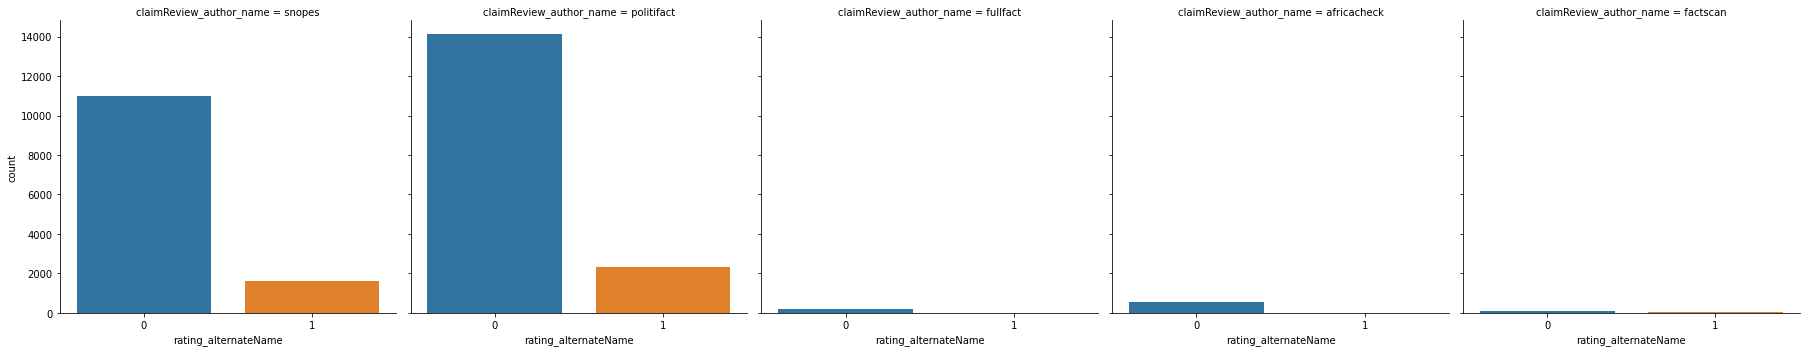

In [30]:
sns.catplot(x='rating_alternateName',col='claimReview_author_name',kind='count',data=df2)

**On recupere maintenant les sujets des assertions**

In [127]:
categories_sorting = Counter(df2.extra_tags)
categories_sorting.most_common(8)

[('ASP Article', 4386),
 ('Economy', 1289),
 ('Health Care', 1170),
 ('supernatural', 1136),
 ('Candidate Biography', 854),
 ('Education', 850),
 ('Elections', 715),
 ('Crime', 625)]

**Visualisation des catégories**

Chaque assertion est taggée par une catégorie. Nous allons prendre les catégories qui reviennent le plus pour visualiser les valeurs des assertions qui leur sont reliées.

In [34]:
def get_n_most_common(n):
    count = Counter(df2.extra_tags)
    most_common = count.most_common(n)
    return most_common

On supprime la catégorie 'nan' :

In [35]:
#On enlève la première catégorie puisqu'on sait que c'est 'nan'
def get_n_categories_distribution(n):
    most_common = get_n_most_common(n)
    categories_distribution = most_common[1:len(most_common)]
    return categories_distribution

On extrait le nom des catégories :

In [36]:
def get_n_noms_categories(n):
    categories_distribution = get_n_categories_distribution(n)
    categories = [x[0] for x in categories_distribution];
    return categories

In [37]:
def get_dict_data_with_n_categories(n):
    categories = get_n_noms_categories(n)
    dict = {'category' : [],
        'faux/vrai' : []
    }
    
    nbLignes, nbColonnes = df2.shape
    
    idx = 0
    while idx < nbLignes:
        current_categorie = df2['extra_tags'][idx]
        if isinstance(current_categorie, str) and current_categorie:
            #print(idx, " : ", current_categorie)       
            if (current_categorie in categories):
                dict['category'].append(current_categorie)
                dict['faux/vrai'].append(df2['rating_alternateName'][idx])         
        idx+=1
    return dict

On veut pouvoir afficher les 5 catégories les plus retrouvées et afficher la distribution des classes qui leur est associée :

30239


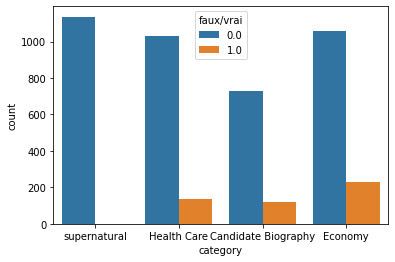

In [38]:
print(len(df2['extra_tags']))
dict = get_dict_data_with_n_categories(5)

categoriesDF = pd.DataFrame.from_dict(dict)

ax = sns.countplot(x="category", hue="faux/vrai", data=categoriesDF)

On peut déjà voir que les claims de la catégorie 'supernatural' sont toutes fausses. La catégorie peut donc jouer un rôle important dans la prédiction d'une assertion.

<H1> Classification </H1>

La phase de pré-traitement est maintenant terminée. Nous allons pouvoir sauvegarder notre dataset préparé et ainsi passer à la phase de classification.


In [40]:
df_majority = df2[df2.rating_alternateName==0]
df_minority = df2[df2.rating_alternateName==1]

df_majority_downsampled = resample(df_majority, replace = False,n_samples = 4594,random_state=123)
df_downsampled = pd.concat([df_majority_downsampled,df_minority])

df_downsampled.rating_alternateName.value_counts()
display(df_downsampled)
print(df_downsampled.shape)
print(df_downsampled[df2.rating_alternateName==1].count())

,claimReview_author_name,claimReview_datePublished,claimReview_source,extra_tags,rating_alternateName,claimReview_Cleaned,minimized_urls,fixed_entities,fixed_score_entities,fixed_subject
10348,snopes,2001-10-05,snopes,naked,0,video captur strang apocalypt sound come sky a...,NaN,NaN,0.544079,NaN
2156,snopes,2017-11-06,snopes,antifa,0,support alexandria suggest eat babi combat cli...,snopes.com,Alexandria Ocasio-Cortez,0.560000,NaN
1224,snopes,2018-05-22,snopes,boy scouts of america,0,motorist fine nine hundr licens suspend three ...,snopes.com,NaN,0.544079,NaN
6794,snopes,2015-04-16,snopes,marilyn monroe,0,donald trump elect presid pope franci said los...,donotlink.com,Donald Trump,0.690000,NaN
27338,politifact,2018-11-06,politifact,Elections,0,scottwalk told firefight need worri act ten sa...,snopes.com,NaN,0.544079,NaN
...,...,...,...,...,...,...,...,...,...,...
30220,factscan,2015-03-15,factscan,CPC,1,got six billion opioid get rid scourg take cou...,openparliament.ca,Opioid,0.544079,NaN
30222,factscan,2015-03-11,factscan,Jobs,1,horribl law requir children separ parent cross...,cbc.ca,NaN,0.544079,NaN
30230,factscan,2015-02-20,factscan,genocide,1,irand ultim would guarante iran nuclear bomb c...,openparliament.ca,Iran,0.544079,Iran
30231,factscan,2015-02-19,factscan,Climate Change,1,perpetr school shoot drug mani case mani young...,cbc.ca,Methylphenidate,0.544079,NaN


(8606, 10)
claimReview_author_name      4012
claimReview_datePublished    4012
claimReview_source           4012
extra_tags                   4012
rating_alternateName         4012
claimReview_Cleaned          4012
minimized_urls               4012
fixed_entities               4012
fixed_score_entities         4012
fixed_subject                4012
dtype: int64


/home/anas/Bureau/m1-aigle-s2/HMIN232M-DataScienceMethods/env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [41]:
#On met notre colonne de classe à la fin pour améliorer la lisibilité

df_downsampled = df_downsampled[[c for c in df_downsampled if c not in ['rating_alternateName']] + ['rating_alternateName']]

**Définition de y**

In [42]:
array = df_downsampled.values
y = array[:,9]
y=y.astype('int')

print("y = ")
display(y[:5])


y = 


array([0, 0, 0, 0, 0])

**Définition des features et de leur traitement respectif** : ici nous recuperons grace au coefficient de correlation de Pearson les features interessantes

10348      (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
2156       (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
1224       (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
6794       (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
27338      (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
                               ...                        
30220      (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
30222      (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
30230      (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
30231      (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
30234      (0, 8978)\t0.3221307599796534\n  (0, 423)\t0...
Name: claimReview_Cleaned, Length: 8606, dtype: object

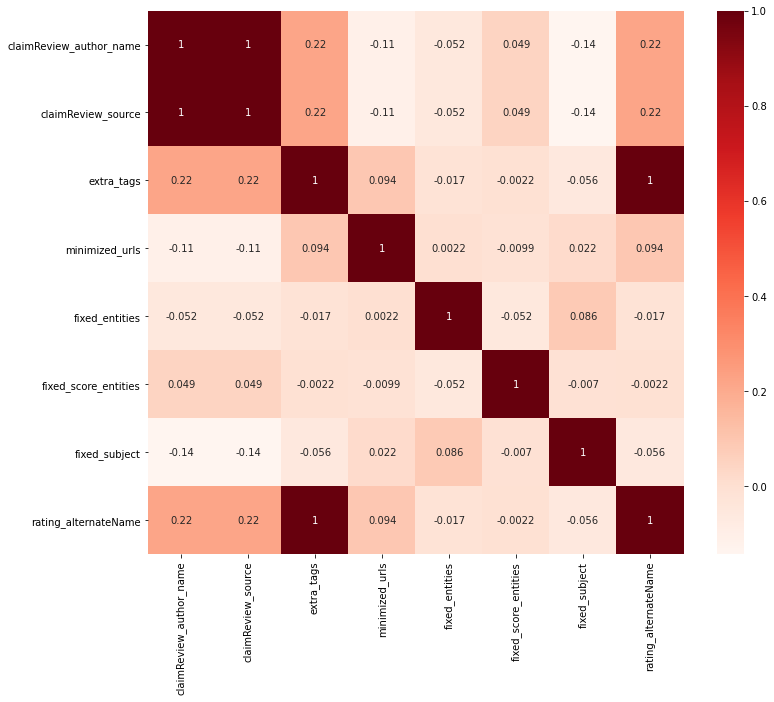

claimReview_author_name    0.219561
claimReview_source         0.219561
extra_tags                 1.000000
rating_alternateName       1.000000
Name: rating_alternateName, dtype: float64


In [43]:
class_label_encoder = LabelEncoder()
#vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()

df_test_label_encoder = df_downsampled.copy()
df_test_label_encoder['claimReview_Cleaned']
df_test_label_encoder['claimReview_author_name'] = class_label_encoder.fit_transform(df_test_label_encoder['claimReview_author_name'])
df_test_label_encoder['claimReview_source'] = class_label_encoder.fit_transform(df_test_label_encoder['claimReview_source'])
df_test_label_encoder['extra_tags'] = class_label_encoder.fit_transform(df_test_label_encoder['extra_tags'])
df_test_label_encoder['rating_alternateName'] = class_label_encoder.fit_transform(df_test_label_encoder['extra_tags'])
df_test_label_encoder['minimized_urls'] = class_label_encoder.fit_transform(df_test_label_encoder['minimized_urls'])
df_test_label_encoder['fixed_entities'] = class_label_encoder.fit_transform(df_test_label_encoder['fixed_entities'])
df_test_label_encoder['fixed_subject'] = class_label_encoder.fit_transform(df_test_label_encoder['fixed_subject'])
df_test_label_encoder['claimReview_Cleaned'] = vectorizer.fit_transform(df_downsampled['claimReview_Cleaned'])
df_test_label_encoder['claimReview_datePublished'] = vectorizer.fit_transform(df_downsampled['claimReview_datePublished'])

display(df_test_label_encoder['claimReview_Cleaned'])

X4 = df_test_label_encoder.drop("rating_alternateName",1)   #Feature
y4 = df_test_label_encoder["rating_alternateName"]          #Target

#Correlation de Pearson
plt.figure(figsize=(12,10))
cor = df_test_label_encoder.corr()
#cor.head()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#on retire la variable target
cor_target = abs(cor["rating_alternateName"])
#Selection des variables
relevant_features = cor_target[cor_target>0.1]
print(relevant_features)

<h3>Nous pouvons dès a présent configurer notre jeu de test</h3>

In [44]:
validation_size=0.3 #30% du jeu de données pour le test
testsize= 1-validation_size
seed=30

#Séléction de toutes les features
mapper = DataFrameMapper([
('claimReview_author_name', LabelEncoder()),
('claimReview_datePublished', LabelEncoder()),
('claimReview_source', LabelEncoder()),
('extra_tags', LabelEncoder()),
('claimReview_Cleaned', TfidfVectorizer()),
('minimized_urls', LabelEncoder()),
('fixed_entities', LabelEncoder()),
('fixed_score_entities', None),
('fixed_subject', LabelEncoder())])

#Séléction des features selon les indications de la corrélation de Pearson
mapper2 = DataFrameMapper([
     ('claimReview_Cleaned', TfidfVectorizer()),
     ('claimReview_author_name', LabelEncoder()),
     ('claimReview_source', LabelEncoder()),
     ('extra_tags', LabelEncoder())
      ])

#features = mapper.fit_transform(df_downsampled)
features = mapper2.fit_transform(df_downsampled)
print(type(features))
display(features)

X_train,X_test,y_train,y_test=train_test_split(features, 
                                               y, 
                                               train_size=validation_size, 
                                               random_state=seed,
                                               test_size=testsize)

<class 'numpy.ndarray'>


array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 4.000e+00, 4.000e+00,
        1.103e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.000e+00, 4.000e+00,
        4.460e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 4.000e+00, 4.000e+00,
        5.850e+02],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        9.380e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        1.250e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
        1.800e+02]])

**Nous testons notre jeu de test avec un premier classifieur**

In [ ]:
def printreport(exp, pred):
    print(pd.crosstab(exp, pred, rownames=['Actual'], colnames=['Predicted']))
 
    print('\n \n')
    print(classification_report(exp, pred))

clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
 
printreport(y_test, predicted)

**Nous testons nos models sur differents classifieurs**

In [54]:
models = []
models.append(('LSVC', LinearSVC(max_iter=3000, dual = False)))
models.append(('SGD', SGDClassifier()))
models.append(('LR', LogisticRegression(max_iter=3000)))
#models.append(('RFC', RandomForestClassifier()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVC', SVC(gamma='auto')))
#models.append(('XGB', XGBClassifier()))
models.append(('MNB', MultinomialNB()))

In [55]:
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    start_time = time()
    cv_results = cross_val_score(model, features, y, cv=kfold, scoring=scoring)
    print (model.get_params())
    print ("Time pour",name," ",time() - start_time)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 3000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
Time pour LSVC   3.915306806564331
LSVC: 0.565765 (0.158388)
{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Time pour SGD   115.73175144195557
SGD: 0.469526 (0.425219)
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 3000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'ver

**Grâce aux résultats obtenus nous pouvons comparer les algorithmes pour connaitre le plus performant**

[Text(0, 0, 'LSVC'),
 Text(0, 0, 'SGD'),
 Text(0, 0, 'LR'),
 Text(0, 0, 'NB'),
 Text(0, 0, 'MNB')]

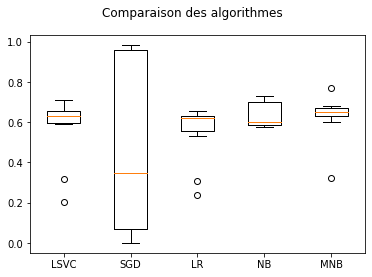

In [56]:
fig = plt.figure()
fig.suptitle('Comparaison des algorithmes')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

On continue avec LSVC, SGD et LR pour essayer d'améliorer les paramètres. (NB ne peut pas être amélioré)

Voici la courbe ROC qu'on obtient avec Logistic Regression :

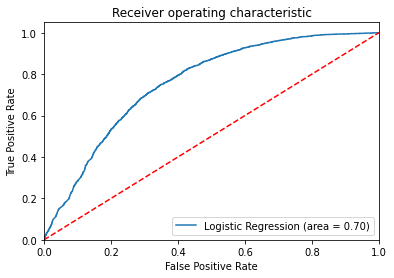

In [101]:
clf.fit(X_train, y_train)
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Plus la courbe est éloignée de la barre rouge (qui est un classifieur aléatoire) et meilleur le modèle est. On va essayer par la suite de l'améliorer.

Lançons un Gridsearch sur nos classifiers et sur ces paramètres :

In [90]:
classifiers = {
     'LinearSVC':  LinearSVC(max_iter=3000, dual = False),
    'LogisticRegression': LogisticRegression(max_iter=3000)
}

params = {'LinearSVC': [{'C': [0.001,0.01,0.1, 1, 10, 100, 1000]}],
          'LogisticRegression' : [{'C': [0.001,0.01,0.1,1,10,100,1000] }]
        }


In [86]:
class Result:
     def __init__(self,name, score, parameters):
         self.name = name
         self.score = score
         self.parameters = parameters
     def __repr__(self):
         return repr((self.name, self.score, self.parameters))
        
def make_grid_search(classifiers, params):
    results = []
    for key,value in classifiers.items():
        gd_sr = GridSearchCV(estimator=value,  
                         param_grid=params[key],
                         scoring='accuracy',
                         cv=5,
                         n_jobs=-1,
                         iid=True, verbose = 41)
        #Verbose pour avoir des messages sur le déroulement
        gd_sr.fit(X_train, y_train)  
        RES=Result(key,gd_sr.best_score_,gd_sr.best_estimator_)
        results.append(RES)   
    return results
        
results = make_grid_search(classifiers, params)
results=sorted(results, key=lambda RES: RES.score, reverse=True) 

print ('Le meilleur resultat : \n')
print ('Classifier : ',results[0].name, 
       ' score %0.2f' %results[0].score, 
       ' avec ',results[0].parameters,'\n')

print ('Tous les résultats : \n')
for result in results:
    print ('Classifier : ',result.name, 
           ' score %0.2f' %result.score, 
           ' avec ',result.parameters,'\n')



Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  13 out of  35 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  14 out of  35 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  13 out of  35 | elapsed:   11.3s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done  14 out of  35 | elapsed:   11.9s remaining:   17.8s
[Parallel(n_jobs=

Le meilleur resultat : 

Classifier :  LogisticRegression  score 0.70  avec  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Tous les résultats : 

Classifier :  LogisticRegression  score 0.70  avec  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Classifier :  LinearSVC  score 0.70  avec  LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi

On essaye de lancer un RandomizedSearch sur LogisticRegression pour voir si on peut mieux faire :

In [99]:
penalty = ['l1', 'l2']
C = uniform(loc=0, scale=4)

hyperparameters = {'C':C, 'penalty':penalty}

clf = RandomizedSearchCV(LogisticRegression(), hyperparameters, random_state=1, n_iter=20, cv=5, n_jobs=-1, verbose=41)

best_model = clf.fit(features, y)

best_penalty = best_model.best_estimator_.get_params()['penalty']
best_c = best_model.best_estimator_.get_params()['C']
print('Best Penalty:', best_penalty)
print('Best C:', best_c)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

Best Penalty: l2
Best C: 3.730229437354635


array([0, 1, 0, ..., 0, 1, 0])

Appliquons maintenant les paramètres trouvés avec RandomizedSearch :

In [100]:
seed=7

k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
clf = LogisticRegression(C=best_c, penalty=best_penalty)

scoring = 'accuracy'
t0 = time()
score = cross_val_score(clf, features, y, cv=k_fold, scoring=scoring)
print("Réalisé en %0.3fs" % (time() - t0))

print('Les différentes accuracy pour les 10 évaluations sont : \n',
      score,'\n')
print ('Accuracy moyenne : ',score.mean(), 
       ' standard deviation', score.std())

Réalisé en 44.683s
Les différentes accuracy pour les 10 évaluations sont : 
 [0.74448316 0.70034843 0.69105691 0.70034843 0.69802555 0.69337979
 0.70930233 0.73139535 0.68837209 0.69883721] 

Accuracy moyenne :  0.7055549253166952  standard deviation 0.01734038136119779


Une dernière tentative de recherche de paramètres avec ParameterGrid pour LogisticRegression :

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   17.7s remaining:   53.1s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   18.0s remaining:   29.9s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   20.9s remaining:   20.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   25.4s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   27.4s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   39.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   39.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.1s finished


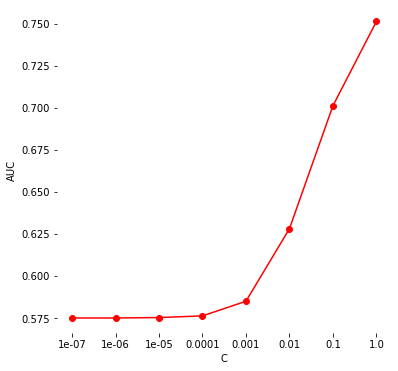

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 0.7513614847463662


In [104]:
grid = {
    'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)
LR_bestModel, bestScore, allModels, allScores = pf.bestFit(LogisticRegression, paramGrid,
           X_train, y_train, X_test, y_test, metric = roc_auc_score,scoreLabel = "AUC")

print(LR_bestModel, bestScore)

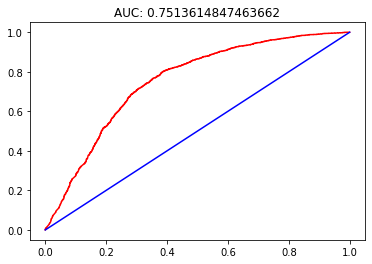

In [77]:
def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()
    
plot_roc_auc(y_test, bestModel.predict_proba(X_test))

Finalement, nous avons réussi à améliorer son score comparé à la première courbe.
Maintenant, on va suivre le même principe sur l'autre classifier qu'on avait séléctionné (SGD) pour voir s'il peut rivaliser.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    1.8s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.7s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.8s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    4.9s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.1s finished


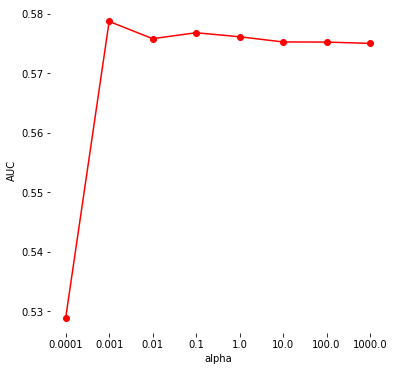

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False) 0.5786816722108523


In [83]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score,
           scoreLabel = "AUC")

print(bestModel, bestScore)

Finalement, le meilleur classifieur qu'on puisse avoir pour notre jeu de données à leur état actuel est LogisticRegression.


Sauvegarde de notre meilleur modèle de LogisticRegression :

In [105]:
#bestModel correspond 

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(LR_bestModel, open(filename, 'wb'))

**Pour conclure, on va appliquer notre modèle sauvegardé à un échantillon aléatoire de données pour tester son efficacité.**

In [124]:
clf_loaded = pickle.load(open(filename, 'rb'))

print ("Sélection aléatoire de 20 claims \n")
from random import randint

new_mapper = DataFrameMapper([
     ('claimReview_Cleaned', TfidfVectorizer()),
     ('claimReview_author_name', LabelEncoder()),
     ('claimReview_source', LabelEncoder()),
     ('extra_tags', LabelEncoder())
      ])

features = new_mapper.fit_transform(df_downsampled)

sample_new = []
samples=[]
samples_result = []

for i in range(1,20):
    val=randint(1,len(features)-1)
    sample_new.append(val)
    samples.append(features[val])
    samples_result.append(y[val])

result = clf_loaded.predict(samples)

print ("Valeurs réelles vs. valeurs prédites\n") 
for i in range(len(result)):
    print ("Claim : ",sample_new[i], 
           "\t Valeur réelle : ", 
           samples_result[i], 
           " Prédiction : ",
           result [i])

Sélection aléatoire de 20 claims 

Valeurs réelles vs. valeurs prédites

Claim :  6569 	 Valeur réelle :  1  Prédiction :  1
Claim :  2763 	 Valeur réelle :  0  Prédiction :  0
Claim :  5198 	 Valeur réelle :  1  Prédiction :  1
Claim :  7439 	 Valeur réelle :  1  Prédiction :  1
Claim :  5299 	 Valeur réelle :  1  Prédiction :  0
Claim :  8015 	 Valeur réelle :  1  Prédiction :  1
Claim :  5951 	 Valeur réelle :  1  Prédiction :  1
Claim :  2894 	 Valeur réelle :  0  Prédiction :  0
Claim :  8366 	 Valeur réelle :  1  Prédiction :  1
Claim :  6925 	 Valeur réelle :  1  Prédiction :  1
Claim :  1788 	 Valeur réelle :  0  Prédiction :  1
Claim :  6195 	 Valeur réelle :  1  Prédiction :  1
Claim :  6406 	 Valeur réelle :  1  Prédiction :  1
Claim :  7617 	 Valeur réelle :  1  Prédiction :  1
Claim :  2208 	 Valeur réelle :  0  Prédiction :  0
Claim :  2499 	 Valeur réelle :  0  Prédiction :  0
Claim :  6718 	 Valeur réelle :  1  Prédiction :  1
Claim :  8378 	 Valeur réelle :  1  Prédict